In [1]:
import numpy as np, pandas as pd
import sympy as sym
from sympy import symbols, Matrix, solve, simplify

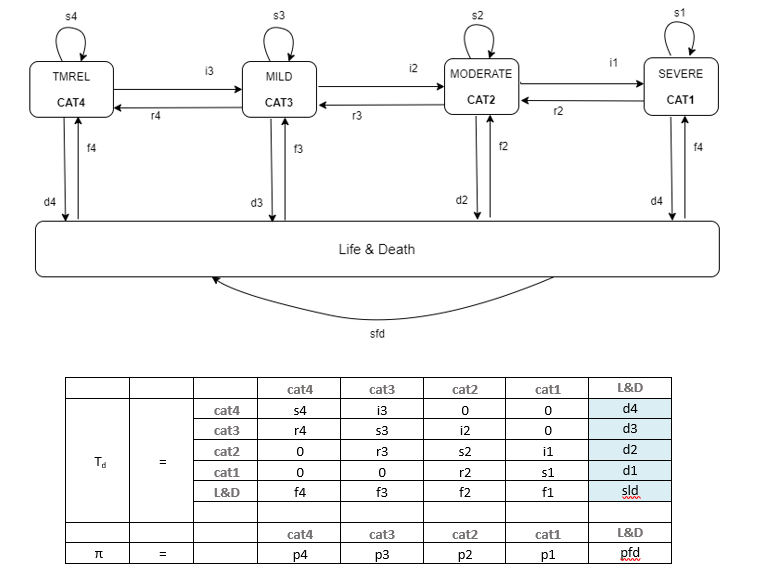

In [2]:
# note typo in above diagram: f1 and d1 mislabelled as f4 and d4 (in/out of SAM)

In [3]:
# # assuming equilibrium:
# p4*s4 + p3*r4 + pfd*f4 = p4
# p4*i3 + p3*s3 + p2*r3 + pfd*f3 = p3
# p3*i2 + p2*s2 + p1*r2 + pfd*f2 = p2
# p2*i1 + p1*s1 + pfd*f1 = p1
# p4*d4 + p3*d3 + p2*d2 + p1*d1 + pfd*sld = pfd

In [4]:
# # rows sum to one:
# s4 + i3 + d4 = 1
# r4 + s3 + i2 + d3 = 1
# r3 + s2 + i1 + d2 = 1
# r2 + s1 + d1 = 1
# f4 + f3 + f2 + f1 + sld = 1

In [5]:
# # adding durations of states
# r2 + d1 = 1/Dsam = 1/40
# r3 + i1 + d2 = 1/Dmam = 1/70

# i2 + r4 + d3 = 1/dur_cat3 = currently unknown

In [6]:
# define symbols
s4, i3 = symbols('s4 i3')
r4, s3, i2 = symbols('r4 s3 i2')
r3, s2, i1 = symbols('r3 s2 i1')
r2, s1 = symbols('r2 s1')
d4, d3, d2, d1, sld = symbols('d4 d3 d2 d1 sld')
f4, f3, f2, f1 = symbols('f4 f3 f2 f1')

p4, p3, p2, p1, pfd = symbols('p4 p3 p2 p1 pfd')

dur_cat3 = sym.Symbol('dur_cat3')

In [7]:
unknowns = [s1,s2,s3,s4,r2,r3,r4,i1,i2,i3,d1,d2,d3,d4,f1,f2,f3,f4]

In [8]:
# # uncomment these if don't want to solve in terms of p_is
# p4 = 0.7
# p3 = 0.2
# p2 = 0.07 
# p1 = 0.03

In [9]:
def add_eq(terms, y, i, A, v):
    """
    For input equation y = sum([coeff*var for var:coeff in {terms}])
    adds right side of equation to to row i of matrix A
    
    adds y to row i of vector v
    """
    for x in terms.keys():
        A[x][i] = terms[x]
    v.iloc[i] = y

In [10]:
# # assuming equilibrium:
# p4*s4 + p3*r4 + pfd*f4 = p4
eq1 = [{s4:p4, r4:p3, f4:pfd}, p4]

# p4*i3 + p3*s3 + p2*r3 + pfd*f3 = p3
eq2 = [{i3:p4, s3:p3, r3:p2, f3:pfd}, p3]

# p3*i2 + p2*s2 + p1*r2 + pfd*f2 = p2
eq3 = [{i2:p3, s2:p2, r2:p1, f2:pfd}, p2]

# p2*i1 + p1*s1 + pfd*f1 = p1
eq4 = [{i1:p2, s1:p1, f1:pfd}, p1]

# p4*d4 + p3*d3 + p2*d2 + p1*d1 + pfd*sld = pfd
eq5 = [{d4:p4, d3:p3, d2:p2, d1:p1}, pfd]

In [11]:
# # rows sum to one:
# s4 + i3 + d4 = 1
eq6 = [{s4:1, i3:1, d4:1}, 1]

# r4 + s3 + i2 + d3 = 1
eq7 = [{r4:1, s3:1, i2:1, d3:1}, 1]

# r3 + s2 + i1 + d2 = 1
eq8 = [{r3:1, s2:1, i1:1, d2:1}, 1]

# r2 + s1 + d1 = 1
eq9 = [{r2:1, s1:1, d1:1}, 1]

# f4 + f3 + f2 + f1 + sld = 1
eq10 = [{f4:1, f3:1, f2:1, f1:1}, 1]

In [12]:
# # adding durations of states
# r2 + d1 = 1/Dsam = 1/40
eq11 = [{r2:1, d1:1}, 1/40]

# r3 + i1 + d2 = 1/Dmam = 1/70
eq12 = [{r3:1, i1:1, d2:1}, 1/70]

# i2 + r4 + d3 = 1/dur_cat3 = currently unknown
eq13 = [{i2:1, r4:1, d3:1}, 1/dur_cat3]

In [13]:
def build_matrix(eqns, unknowns):
    """
    INPUT
    ----
    eqns: a list of sympy equations
    unknowns: a list of sympy unknowns
    ----
    OUTPUT
    ----
    A:  a matrix containing the coefficients of LHS of all eq in eqns.
        nrows = number of equations
        rcols = number of unknowns
    b: an nx1 matrix containing the RHS of all the eqns
    x: a sympy matrix of the unknowns
    """
    n_eqns = len(eqns)
    n_unknowns = len(unknowns)

    # frame for matrix/LHS equations.
    # nrows = n_eqns, ncols = n_unknowns
    A = pd.DataFrame(
        index = range(n_eqns),
        columns = unknowns,
        data = np.zeros([n_eqns,n_unknowns])
    )
    
    # frame for RHS of equations
    b = pd.DataFrame(index = range(n_eqns), columns = ['val'])
    
    # populate LHS/RHS
    i = 0
    for eq in eqns:

        add_eq(eq[0], eq[1], i, A, b)
        i += 1
    
    # convert to sympy matrices
    A = sym.Matrix(A)
    b = sym.Matrix(b)
    x = sym.Matrix(unknowns) #vars to solve for
    
    return A, x, b

In [14]:
# solve in terms of p1, p2, p3, p4, and 
A0, x0, b0 = build_matrix([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12],
                         unknowns)

result_0 = sym.solve(A0 * x0 - b0, x0)

/share/code/beatrixh/miniconda/envs/linalg/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
unknowns

[s1, s2, s3, s4, r2, r3, r4, i1, i2, i3, d1, d2, d3, d4, f1, f2, f3, f4]

In [16]:
pd.DataFrame(np.array(A0), columns = unknowns)

,s1,s2,s3,s4,r2,r3,r4,i1,i2,i3,d1,d2,d3,d4,f1,f2,f3,f4
0,0.0,0.0,0.0,p4,0.0,0.0,p3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pfd
1,0.0,0.0,p3,0.0,0.0,p2,0.0,0.0,0.0,p4,0.0,0.0,0.0,0.0,0.0,0.0,pfd,0.0
2,0.0,p2,0.0,0.0,p1,0.0,0.0,0.0,p3,0.0,0.0,0.0,0.0,0.0,0.0,pfd,0.0,0.0
3,p1,0.0,0.0,0.0,0.0,0.0,0.0,p2,0.0,0.0,0.0,0.0,0.0,0.0,pfd,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p1,p2,p3,p4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
6,0.0,0.0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
7,0.0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1


In [17]:
# the one unknown ends up being i3
result_0

{s1: 0.975000000000000,
 s2: 0.985714285714286,
 s3: d2*p2/p3 + f2*pfd/p3 + f4*pfd/p3 - i3*p4/p3 + 0.00357142857142857*(7.0*p1 - 4.0*p2 + 280.0*p3 - 280.0*pfd)/p3,
 s4: -d4 - i3 + 1.0,
 r2: d2*p2/p1 + d3*p3/p1 + d4*p4/p1 + 0.025*(p1 - 40.0*pfd)/p1,
 r3: -d2 - f2*pfd/p2 - f3*pfd/p2 - f4*pfd/p2 + 0.00357142857142857*(-7.0*p1 + 4.0*p2 + 280.0*pfd)/p2,
 r4: d4*p4/p3 - f4*pfd/p3 + i3*p4/p3,
 i1: f2*pfd/p2 + f3*pfd/p2 + f4*pfd/p2 + 0.025*(p1 - 40.0*pfd)/p2,
 i2: -d2*p2/p3 - d3 - d4*p4/p3 - f2*pfd/p3 + 0.00357142857142857*(-7.0*p1 + 4.0*p2 + 280.0*pfd)/p3,
 d1: -d2*p2/p1 - d3*p3/p1 - d4*p4/p1 + pfd/p1,
 f1: -f2 - f3 - f4 + 1.0}

In [18]:
#unknowns
# p1, p2, p3, p4,
# i3
# d2 d3 d4
# f2 f3 f4
# pfd

In [19]:
# solve in terms of duration of cat3 instead of i3:
# i2 + r4 = 1/dur_cat3
eq13

[{i2: 1, r4: 1, d3: 1}, 1/dur_cat3]

In [20]:
A1, x1, b1 = build_matrix([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9,eq10,eq11,eq12,eq13],
                         unknowns)
result_1 = sym.solve(A1 * x1 - b1, x1)

/share/code/beatrixh/miniconda/envs/linalg/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [21]:
pd.DataFrame(np.array(A1), columns = unknowns)

,s1,s2,s3,s4,r2,r3,r4,i1,i2,i3,d1,d2,d3,d4,f1,f2,f3,f4
0,0.0,0.0,0.0,p4,0.0,0.0,p3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pfd
1,0.0,0.0,p3,0.0,0.0,p2,0.0,0.0,0.0,p4,0.0,0.0,0.0,0.0,0.0,0.0,pfd,0.0
2,0.0,p2,0.0,0.0,p1,0.0,0.0,0.0,p3,0.0,0.0,0.0,0.0,0.0,0.0,pfd,0.0,0.0
3,p1,0.0,0.0,0.0,0.0,0.0,0.0,p2,0.0,0.0,0.0,0.0,0.0,0.0,pfd,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,p1,p2,p3,p4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
6,0.0,0.0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
7,0.0,1,0.0,0.0,0.0,1,0.0,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
8,1,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1


In [22]:
result_1

{s1: 0.975000000000000,
 s2: 0.985714285714286,
 s3: (dur_cat3 - 1.0)/dur_cat3,
 s4: -d2*p2/p4 - d4 - f2*pfd/p4 - f4*pfd/p4 + 0.00357142857142857*(-7.0*dur_cat3*p1 + 4.0*dur_cat3*p2 + 280.0*dur_cat3*p4 + 280.0*dur_cat3*pfd - 280.0*p3)/(dur_cat3*p4),
 r2: d2*p2/p1 + d3*p3/p1 + d4*p4/p1 + 0.025*(p1 - 40.0*pfd)/p1,
 r3: -d2 - f2*pfd/p2 - f3*pfd/p2 - f4*pfd/p2 + 0.00357142857142857*(-7.0*p1 + 4.0*p2 + 280.0*pfd)/p2,
 r4: d2*p2/p3 + d4*p4/p3 + f2*pfd/p3 + 0.00357142857142857*(7.0*dur_cat3*p1 - 4.0*dur_cat3*p2 - 280.0*dur_cat3*pfd + 280.0*p3)/(dur_cat3*p3),
 i1: f2*pfd/p2 + f3*pfd/p2 + f4*pfd/p2 + 0.025*(p1 - 40.0*pfd)/p2,
 i2: -d2*p2/p3 - d3 - d4*p4/p3 - f2*pfd/p3 + 0.00357142857142857*(-7.0*p1 + 4.0*p2 + 280.0*pfd)/p3,
 i3: d2*p2/p4 + f2*pfd/p4 + f4*pfd/p4 + 0.00357142857142857*(7.0*dur_cat3*p1 - 4.0*dur_cat3*p2 - 280.0*dur_cat3*pfd + 280.0*p3)/(dur_cat3*p4),
 d1: -d2*p2/p1 - d3*p3/p1 - d4*p4/p1 + pfd/p1,
 f1: -f2 - f3 - f4 + 1.0}

In [23]:
#unknowns
# p1, p2, p3, p4,
# dur_cat3
# d2 d3 d4
# pfd